<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Aula 22 - Aplicando Inteligência Artificial Para Prever a Média Mensal de Vendas</font></b></strong>

Na aula anterior criamos nosso primeiro modelo de Deep Learning para a Previsão da Média Mensal de Vendas. Agora vamos trabalhar na otimização do modelo e começaremos com um modelo Stacked LSTM.

**Deep Learning - Modelo Stacked LSTM**

O Modelo Stacked LSTM nada mais é do que um Modelo com mais de uma camada LSTM. A camada LSTM é o diferencial do modelo e adicionando mais uma camada esperamos aumentar o poder de acurácia do modelo final.

Nesta aula vamos discutir ainda como calcular o número de neurônios em cada camada.

Esta aula considera algu conhecimento em Deep Learning e esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura antes de prosseguir nesta aula.

**No Google Colab, altere seu Runtime para executar o treinamento usando GPU**.


Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.

!pip install -q -U watermark

In [2]:
# The new versions of Pandas and Matplotlib bring several warning messages to the developer. Let's disable this.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports for data manipulation
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports for data Visualization
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports for metrics and model performance
import sklearn
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# Imports for formatting graphics
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
matplotlib.style.use('ggplot')
%matplotlib inline


In [3]:
#Versions of packages used in this jupyter notebook
%reload_ext watermark
%watermark -a "Data Scientist Rodolfo Terra" --iversions

Author: Data Scientist Rodolfo Terra

seaborn    : 0.11.0
sys        : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
statsmodels: 0.12.0
matplotlib : 3.3.2
keras      : 2.4.3
pandas     : 1.1.3
numpy      : 1.19.2
sklearn    : 0.23.2



## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

### Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [4]:
# Load the data
dados = pd.read_csv('https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset6.csv')

In [5]:
# shape
dados.shape

(9994, 21)

In [6]:
# Columns
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [7]:
# View the data
dados.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [8]:
# Statistical Summart
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [9]:
# Chacking missing values - we have no missing values in the dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [10]:
# Adjusting the column names so that they are all lowercrase
dados.columns = map(str.lower, dados.columns)

In [11]:
# We will replace the spaces and dashes in the columnb names with '-'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [12]:
# Checking out 
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [13]:
# Separating data by category

df_tecnologia = dados.loc[dados['category'] == 'Technology']

Agora vamos preparar as séries temporais.

In [14]:
# Aggregating sales by order date
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()

In [15]:
# How is each dataset doing?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [16]:
# Putting the date as an index
ts_tecnologia = ts_tecnologia.set_index('order_date')

In [17]:
# View the serie
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

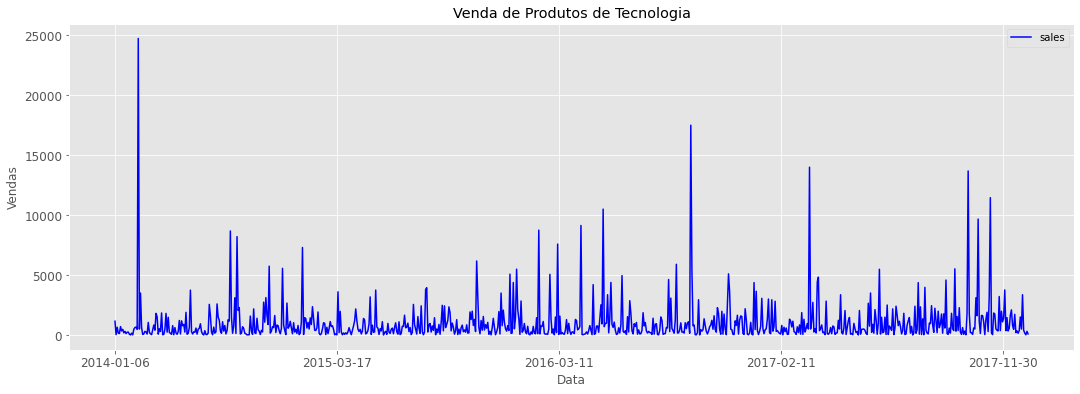

In [18]:
# Sale of technology Products
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo.

In [19]:
# Chaging the index type
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [20]:
# Checking the index type
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [21]:
# Checking the index type
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [23]:
# Resampling data for monthly frequency
# Using the average value of daily sales - we define the month as an index
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()

In [24]:
# Checking the resulting type
type(media_vendas_tecnologia)

pandas.core.series.Series

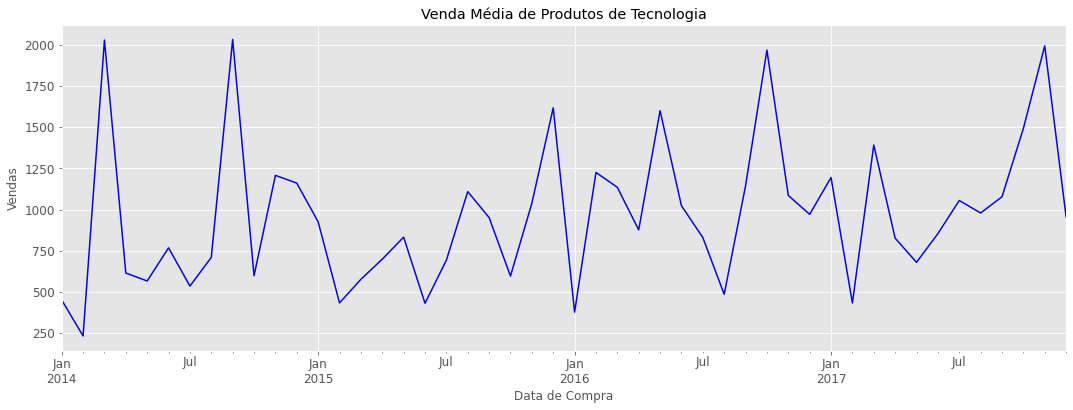

In [26]:
# Average Sale of technology Products
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

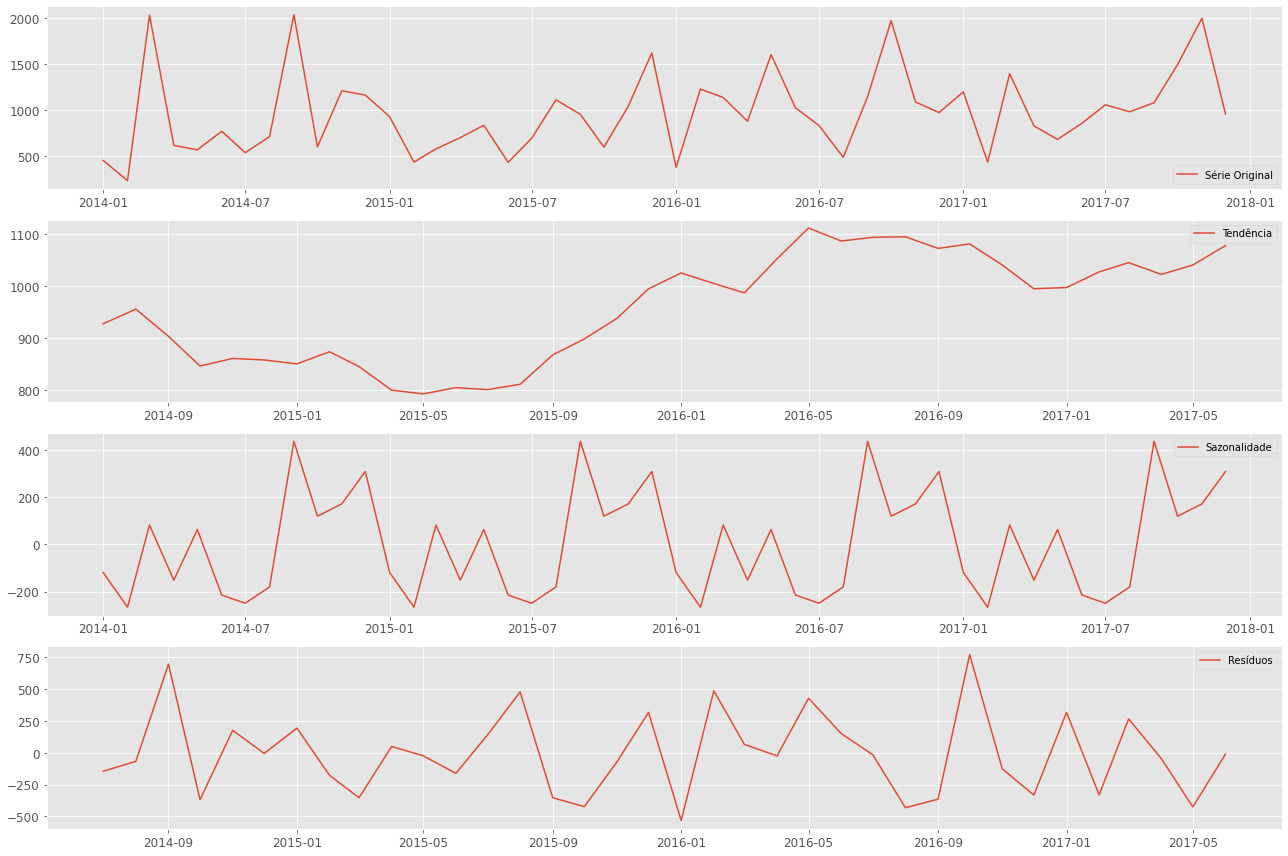

In [27]:
# Decomposition of the average salers time series of technology products
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [28]:
# Function to test stationarity
def testa_estacionaridade(serie):
    
    # Calculates mobile statistics
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot of mobile statistics
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Dickey-Fuller test:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Test
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatting the output
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])


    # Loop for each test output item
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Test the valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

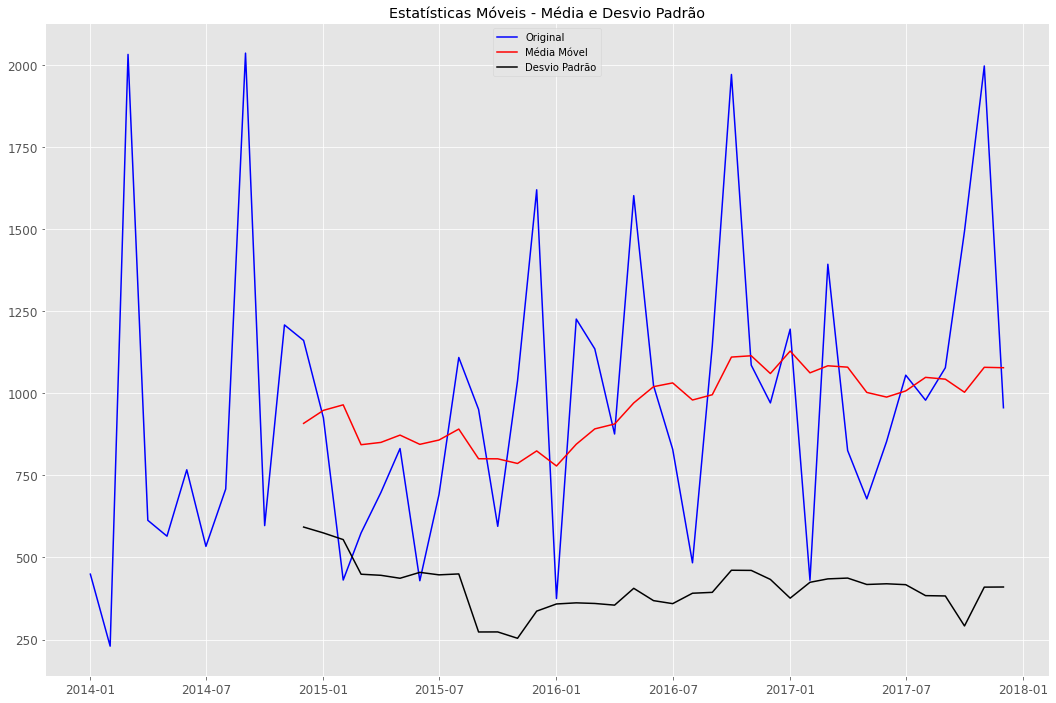


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [29]:
# Chacks whether the series is stationary
testa_estacionaridade(media_vendas_tecnologia)

### Função Para o Cálculo da Acurácia

In [30]:
# Function
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

## O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning

Nesta aula tentaremos aumentar a precisão do nosso modelo aumentando de forma significativa o número de camadas e neurônios.

Execute o modelo e tire suas conclusões.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados.

In [45]:
# Tranforms the time series into a supervised learning problem
def timeseries_to_supervised(data, lag = 1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis = 1)
    df.fillna(0, inplace = True)
    return df

In [46]:
# Creates a differentiated series make the time sires stationary
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [47]:
# Inverts differetiated value
def inverse_difference(history, yhat, interval = 1):
    return yhat + history[-interval]

In [48]:
# Transforms the times series into stationary
raw_values = media_vendas_tecnologia.values
diff_values = difference(raw_values, 1)

In [49]:
# Transforms the time series into supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [51]:
# Creation of the training and test dataset
trainset, testset = supervised_values[0:-12], supervised_values[-12:]

In [58]:
# We normalize the data by scaling the interval [-1, 1]
def scale(train, test):
    scaler = MinMaxScaler(feature_range = (-1, 1))
    scaler = scaler.fit(train)
    
    # Transform training data
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # Transform test data
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

In [59]:
# Reverses the scale in forecasts to the original scale
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [60]:
# Transforms the scale of the data
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [63]:
# Function for the LSTM model
def train_lstm(train, nb_epoch):
    
    # Adjust the shape of the data
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # Model
    modelo_lstm = Sequential()
    modelo_lstm.add(LSTM(200, activation = 'relu', return_sequences = True, input_shape = (1, 1)))
    modelo_lstm.add(LSTM(100, activation = 'relu', return_sequences = True))
    modelo_lstm.add(LSTM(50, activation = 'relu', return_sequences = True))
    modelo_lstm.add(LSTM(25, activation = 'relu'))
    modelo_lstm.add(Dense(20, activation = 'relu'))
    modelo_lstm.add(Dense(10, activation = 'relu'))
    modelo_lstm.add(Dense(1))
    
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

    modelo_lstm.fit(X, y, epochs = nb_epoch, verbose = 1)
    
    return modelo_lstm

Vamos treinar por 5 mil épocas.

In [64]:
# Traning
lstm_model = train_lstm(train_scaled, 500)

Epoch 1/500
2/2 [==============================] - 6s 18ms/step - loss: 0.1844
Epoch 2/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1806
Epoch 3/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1805
Epoch 4/500
2/2 [==============================] - 0s 8ms/step - loss: 0.1790
Epoch 5/500
2/2 [==============================] - 0s 7ms/step - loss: 0.1788
Epoch 6/500
2/2 [==============================] - 0s 10ms/step - loss: 0.1887
Epoch 7/500
2/2 [==============================] - 0s 7ms/step - loss: 0.1861
Epoch 8/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1859
Epoch 9/500
2/2 [==============================] - 0s 7ms/step - loss: 0.1771
Epoch 10/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1851
Epoch 11/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1822
Epoch 12/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1722
Epoch 13/500
2/2 [==============================] - 0s 5ms/

2/2 [==============================] - 0s 9ms/step - loss: 0.1258
Epoch 105/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1253
Epoch 106/500
2/2 [==============================] - 0s 8ms/step - loss: 0.1252
Epoch 107/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1227
Epoch 108/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1240
Epoch 109/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1240
Epoch 110/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1203
Epoch 111/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1192
Epoch 112/500
2/2 [==============================] - 0s 7ms/step - loss: 0.1240
Epoch 113/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1125
Epoch 114/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1241
Epoch 115/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1119
Epoch 116/500
2/2 [==============================] - 0

2/2 [==============================] - 0s 6ms/step - loss: 0.1329
Epoch 207/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1276
Epoch 208/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1310
Epoch 209/500
2/2 [==============================] - 0s 7ms/step - loss: 0.1304
Epoch 210/500
2/2 [==============================] - 0s 8ms/step - loss: 0.1285
Epoch 211/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1278
Epoch 212/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1186
Epoch 213/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1236
Epoch 214/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1211
Epoch 215/500
2/2 [==============================] - 0s 16ms/step - loss: 0.1239
Epoch 216/500
2/2 [==============================] - 0s 9ms/step - loss: 0.1257
Epoch 217/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1159
Epoch 218/500
2/2 [==============================] - 

2/2 [==============================] - 0s 8ms/step - loss: 0.1158
Epoch 309/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1247
Epoch 310/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1226
Epoch 311/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1117
Epoch 312/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1198
Epoch 313/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1186
Epoch 314/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1197
Epoch 315/500
2/2 [==============================] - 0s 7ms/step - loss: 0.1200
Epoch 316/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1175
Epoch 317/500
2/2 [==============================] - 0s 7ms/step - loss: 0.1182
Epoch 318/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1193
Epoch 319/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1188
Epoch 320/500
2/2 [==============================] - 0

2/2 [==============================] - 0s 6ms/step - loss: 0.1204
Epoch 411/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1212
Epoch 412/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1203
Epoch 413/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1218
Epoch 414/500
2/2 [==============================] - 0s 8ms/step - loss: 0.1187
Epoch 415/500
2/2 [==============================] - 0s 7ms/step - loss: 0.1211
Epoch 416/500
2/2 [==============================] - 0s 31ms/step - loss: 0.1168
Epoch 417/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1201
Epoch 418/500
2/2 [==============================] - 0s 7ms/step - loss: 0.1204
Epoch 419/500
2/2 [==============================] - 0s 7ms/step - loss: 0.1146
Epoch 420/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1188
Epoch 421/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1183
Epoch 422/500
2/2 [==============================] - 

In [66]:
# Forecast across the training data set to build the forecast state
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped)

array([[-1.18918419e-02],
       [-6.42223237e-03],
       [-1.05734062e+00],
       [ 2.27050930e-02],
       [-1.07978228e-02],
       [-1.52261592e-02],
       [-6.02318672e-03],
       [-1.48405023e-02],
       [-7.84283638e-01],
       [ 2.39907727e-02],
       [-2.20989808e-01],
       [-1.08211376e-02],
       [-5.95543720e-03],
       [ 6.42015599e-04],
       [-1.45250829e-02],
       [-1.43073015e-02],
       [-1.44271553e-02],
       [-1.72738591e-03],
       [-1.59256589e-02],
       [-8.71428326e-02],
       [-8.09934922e-03],
       [-2.87697464e-03],
       [-1.04867674e-01],
       [-2.00391322e-01],
       [ 1.21684028e-02],
       [-4.08791304e-01],
       [-9.79492720e-03],
       [-5.27149811e-03],
       [-3.06083977e-01],
       [ 1.43942796e-03],
       [-7.12775998e-03],
       [-3.12884850e-03],
       [-2.56620586e-01],
       [-3.87923956e-01],
       [ 3.75656039e-03]], dtype=float32)

In [67]:
# We make a one-step forecast 
def forecast_lstm(model, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X)
    return yhat[0,0]

In [68]:
# Direct validation on test data

# List for predictions
previsoes_lstm = list()

# Forecasts
for i in range(len(test_scaled)):
    
    # Adjust the shape of the data
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    
    # Forecasts
    yhat = forecast_lstm(lstm_model, X)
    
    # Reverses the scale
    yhat = invert_scale(scaler, X, yhat)
    
    # REverses diffentiation
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    
    # Stores the forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))

Mês = 1, Valor Previsto = 1137.257241, Valor Esperado = 970.554870
Mês = 2, Valor Previsto = 1351.696933, Valor Esperado = 1195.218071
Mês = 3, Valor Previsto = 616.628241, Valor Esperado = 430.501714
Mês = 4, Valor Previsto = 749.669350, Valor Esperado = 1392.859250
Mês = 5, Valor Previsto = 1009.378799, Valor Esperado = 825.559133
Mês = 6, Valor Previsto = 846.352282, Valor Esperado = 678.329400
Mês = 7, Valor Previsto = 1010.619568, Valor Esperado = 853.055000
Mês = 8, Valor Previsto = 1211.939887, Valor Esperado = 1054.996636
Mês = 9, Valor Previsto = 1144.014653, Valor Esperado = 978.842333
Mês = 10, Valor Previsto = 1236.585573, Valor Esperado = 1077.704120
Mês = 11, Valor Previsto = 1535.784166, Valor Esperado = 1493.439227
Mês = 12, Valor Previsto = 1939.664679, Valor Esperado = 1996.750920


In [69]:
# Calculate and prinbt model preformance
dados_teste_original = media_vendas_tecnologia[-12:]
modelo_lstm_performance = performance(dados_teste_original, previsoes_lstm)
modelo_lstm_performance

MSE das previsões é 239743.18
RMSE das previsões é 489.64
MAPE das previsões é 42.56


Observe o que aconteceu. Uma das técnicas de aprendizagem de máquina do planeta agora é o pior modelo que criamos entre todas as versões até aqui. 

E o que deveria ter melhorado a precisão do modelo (mais camadas e mais neurônios) na verdade de mostrou um desastre. Por isso, como profissional, você deve dominar as técnicas do processo e não contar com a apenas uma estratégia. cada problema vai querer uma abordagem diferente.

Vamos finalizar o trabalho como fizemos nas aulas anteriores.

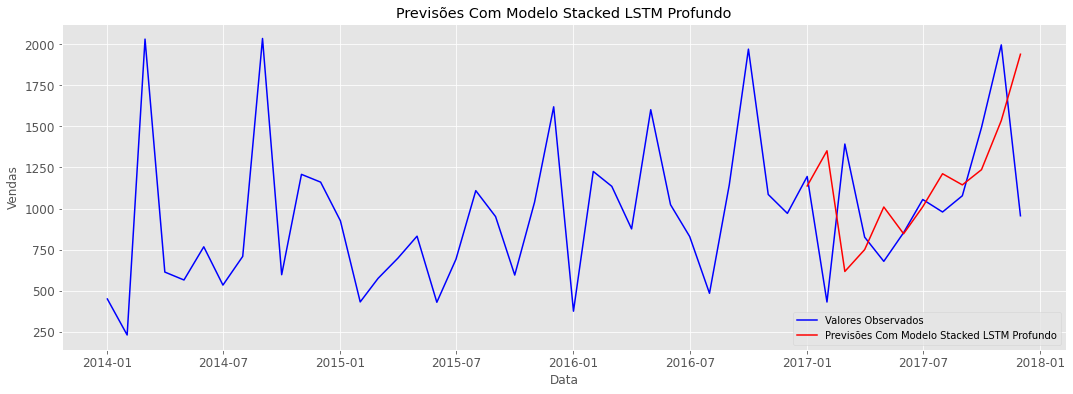

In [70]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(media_vendas_tecnologia.index, 
         media_vendas_tecnologia.values,
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(media_vendas_tecnologia[36:].index, 
         previsoes_lstm,
         label = 'Previsões Com Modelo Stacked LSTM Profundo', 
         color = 'Red')

plt.title('Previsões Com Modelo Stacked LSTM Profundo')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

Vamos fazer o Forecasting para 12 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [71]:
# Last date of series
media_vendas_tecnologia.index[-1]

Timestamp('2017-12-01 00:00:00', freq='MS')

In [72]:
# Create a sequence of dates from the last date of our original series
datas_para_prever_forecasting = [media_vendas_tecnologia.index[-1] + DateOffset(months = x) for x in range(0, 13)]

In [73]:
#View
datas_para_prever_forecasting

[Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00')]

In [74]:
# Our original series is a pd.Series object
type(media_vendas_tecnologia)

pandas.core.series.Series

In [75]:
# Objects of type pd.Series give you more work to manipulate. We will convert the original series into a dataframe.
df_original = pd.DataFrame(media_vendas_tecnologia)

In [76]:
#View Data
df_original.head()

,sales
order_date,
2014-01-01,449.041429
2014-02-01,229.787143
2014-03-01,2031.948375
2014-04-01,613.028933
2014-05-01,564.698588


In [77]:
# Let's now create a new dataframe
# The index (date) will be the sequence of future dates
# The data column name we extracted from the original series
# ATTENTION: We are not extracting the data from the original series, only the column name
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [78]:
# View the data
# Did you understand why the NaN values? These are future dates, and we now need to include our forecasts.
data_futuras

,sales
2018-01-01,NaN
2018-02-01,NaN
2018-03-01,NaN
2018-04-01,NaN
2018-05-01,NaN
2018-06-01,NaN
2018-07-01,NaN
2018-08-01,NaN
2018-09-01,NaN
2018-10-01,NaN


In [80]:
# We use future dates to extract predictions from our model
df_predict = pd.DataFrame(previsoes_lstm,
                          index = data_futuras.index, columns = ['Prediction'])

In [81]:
# We concatenate the original series with the forecasting values of 12 month in addition to the series
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [82]:
# View the data
df_forecasting

,sales,Prediction
2014-01-01,449.041429,NaN
2014-02-01,229.787143,NaN
2014-03-01,2031.948375,NaN
2014-04-01,613.028933,NaN
2014-05-01,564.698588,NaN
2014-06-01,766.905909,NaN
2014-07-01,533.608933,NaN
2014-08-01,708.435385,NaN
2014-09-01,2035.838133,NaN
2014-10-01,596.900900,NaN


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste, 12 meses que correspondem aos 12 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 12 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.


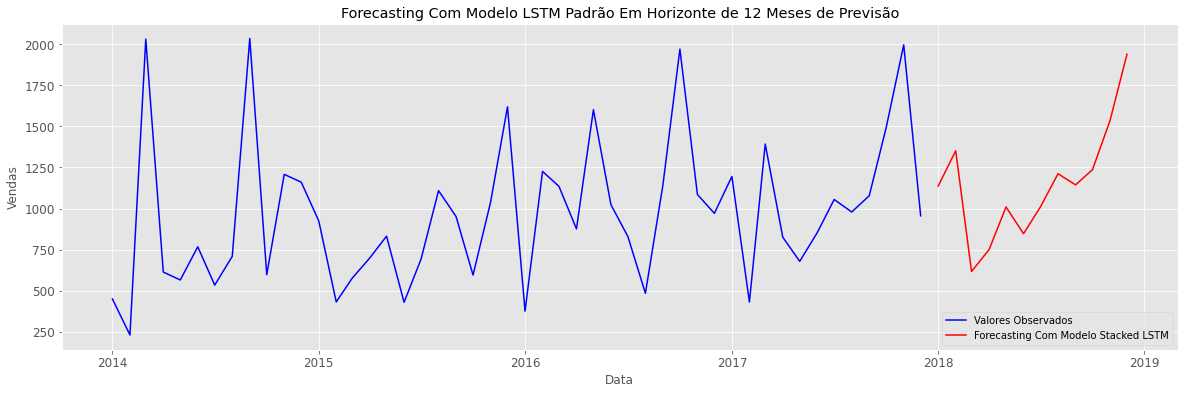

In [83]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(df_forecasting.index, 
         df_forecasting['sales'],
         label = 'Valores Observados',
         color = 'Blue')

# Previsões
plt.plot(df_forecasting.index, 
         df_forecasting['Prediction'],
         label = 'Forecasting Com Modelo Stacked LSTM', 
         color = 'Red')

plt.title('Forecasting Com Modelo LSTM Padrão Em Horizonte de 12 Meses de Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

Graficamente o resultado não parece tão ruim, mas as métricas demonstram que esse modelo é o pior de todos, ainda possa até mesmo ser usado na falta de outra opção.

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA(1,1) - AIC = 550.3, RMSE = 420.2 e MAPE = 29.58
- Aula 16 --> Modelo ARIMA(6,0,2) - AIC = 559.4, RMSE = 401.5 e MAPE = 26.58
- Aula 17 --> Modelo SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC = 176.74, RMSE = 425.89 e MAPE = 34.95
- Aula 18 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC = 146.77, RMSE = 353.57 e MAPE = 30.55
- Aula 19 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) com exog  - AIC = 149.66, RMSE = 341.23 e MAPE = 32.54
- Aula 20 --> Modelo Prophet 1 - RMSE = 347.58 e MAPE = 28.53
- Aula 21 --> Modelo Prophet 2 - RMSE = 325.52 e MAPE = 26.45
- Aula 22 --> Modelo LSTM Padrão - RMSE = 397.12 e MAPE = 31.46
- Aula 23 --> Modelo Stacked LSTM - RMSE = 396.24 e MAPE = 36.35
- Aula 24 --> Modelo Stacked LSTM Profundo - RMSE = 504.52 e MAPE = 46.35

Mas.....ainda não fizemos otimização de hiperparâmetros do modelo! Isso é assunto para a próxima aula.